In [17]:
library(moments)  # skewness
library(corrplot)  # corrplot
library(DAAG)  # cross-validation

Loading required package: lattice


In [2]:
train = read.csv('./train.csv')
test = read.csv('./test.csv')

In [3]:
# apply function: use the given function (is.na) for each column (use 2 for column, and use 1 for row) 
# in the matrix train[, -c(1, 81)].
numNA = colSums(apply(train[, -c(1, 81)], 2, is.na))
number_of_missing = numNA[which(numNA != 0)]  # number of NA's
data_type = sapply(train[,names(which(numNA != 0))], class)  # type of data

In [4]:
drops = c("Alley", "PoolQC", "Fence", "MiscFeature")
train = train[ , !(names(train) %in% drops)]
test = test[ , !(names(test) %in% drops)]

In [5]:
data.type = sapply(train[, -c(1, ncol(train))], class)  # as we've removed 4 variables
cat_var = names(train)[which(c(NA, data.type, NA) == 'factor')]  # categorical variables
numeric_var =  names(train)[which(c(NA, data.type, NA) == 'integer')]  # continuous variables
for (j in cat_var){
    train[, j] = addNA(train[, j])  # addNA treat the NA's as a new level called '<NA>'
    test[, j] = addNA(test[, j])
}

In [6]:
tempVar = c('LotFrontage', 'MasVnrArea', 'GarageYrBlt')
for (j in tempVar){
    na.id = is.na(train[, j])  # binary indicator: NA (1) or not (0)
    tempMedian = median(train[, j], na.rm = TRUE)  # find the median
    train[which(na.id), j] = tempMedian
    train[, paste(j, 'NAInd', sep = '_')] = as.numeric(na.id)  # create a new column
}

In [7]:
for (j in numeric_var){
  na.id = is.na(test[, j])
  if (!any(na.id)){
    next
  }
  test[which(na.id), j] = median(train[, j])
}

In [8]:
# transform SalePrice target to log form
train$SalePrice <- log(train$SalePrice + 1)

# for numeric feature with excessive skewness, perform log transformation
# determine skew for each numeric feature
skewed_feats = sapply(train[, numeric_var], skewness)
# only transform features that exceed a threshold = 0.75 for skewness
skewed_feats = numeric_var[which(skewed_feats > 0.75)]
for(j in skewed_feats) {
  train[, j] = log(train[, j] + 1)
  test[, j] = log(test[, j] + 1)
}

In [24]:
correlations = cor(train[, c(numeric_var, 'SalePrice')])  # correlation matrix
# for those relatively large correlations (> 0.3)
row_indic = apply(correlations, 1, function(x) sum(abs(x) > 0.3) > 1)
correlations = correlations[row_indic, row_indic]

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning 

Warning message in cv.lm(train[, c(names(highCor), "SalePrice")], SalePrice ~ ., :
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 209.8868

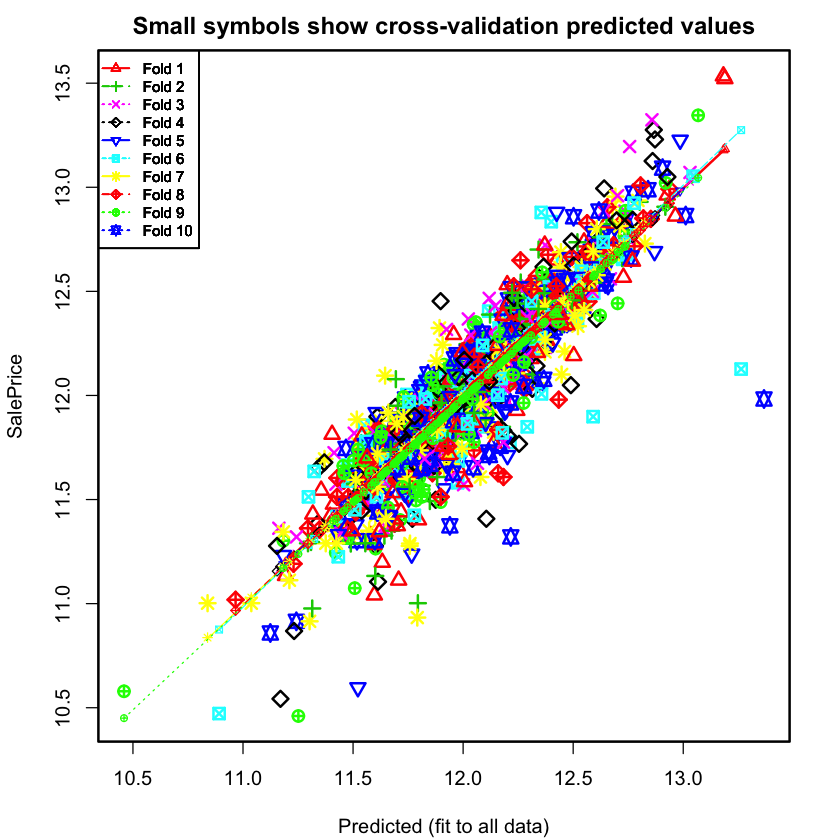

In [44]:
# record those with very large correlation (> 0.6)
highCor = which(abs(correlations[, ncol(correlations)]) > 0.6)
highCor = highCor[-length(highCor)]

model.cv = cv.lm(train[, c(names(highCor), 'SalePrice')], SalePrice ~ ., m=10, seed=29, printit=FALSE)
attr(model.cv, "ms")

In [20]:
mlr = lm(SalePrice ~ ., data = train[, c(names(highCor), 'SalePrice')])
yHat = predict(mlr, newdata = test)
yHat = exp(yHat) - 1

In [21]:
submission = read.csv('./other/sample_submission.csv')
submission$SalePrice = yHat
write.table(submission, 'simple_model.csv', row.names = FALSE, sep = ',')